<a href="https://colab.research.google.com/github/VanChung-Nguyen/RF-RBFNN-for-Phishing-Email-URL-Detection/blob/main/cs650gradproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cuda
Loading URL data...
URL Dataset shape: (651191, 2)
Vectorizing URL text with TF-IDF...
URL Training data shape: (520952, 505)
URL Test data shape: (130239, 505)
Training URL Random Forest...
URL Accuracy: 0.9054507482397746

URL Classification Report:
              precision    recall  f1-score   support

      benign       0.91      0.96      0.93     85621
  defacement       0.94      0.91      0.93     19292
     malware       0.98      0.94      0.96      6504
    phishing       0.79      0.66      0.72     18822

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.90      0.91      0.90    130239


Loading Email data...
Email Columns: ['Unnamed: 0', 'Email Text', 'Email Type']
   Unnamed: 0                                                                                           Email Text      Email Type
0           0  re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hu

100%|██████████| 88/88 [00:05<00:00, 15.91it/s]


Email Embedding time (min): 0.95
Email Class weights: {np.int64(1): 1.274228214146151, np.int64(0): 0.8229022082018927}
KMeans K=32 time (min): 0.02
  K= 32  l2=0.001  VAL weighted F1=0.9195  (min: 0.00)
  K= 32  l2=0.003  VAL weighted F1=0.9195  (min: 0.00)
  K= 32  l2=0.01  VAL weighted F1=0.9195  (min: 0.00)
  K= 32  l2=0.03  VAL weighted F1=0.9195  (min: 0.00)
KMeans K=64 time (min): 0.03
  K= 64  l2=0.001  VAL weighted F1=0.9266  (min: 0.00)
  K= 64  l2=0.003  VAL weighted F1=0.9263  (min: 0.00)
  K= 64  l2=0.01  VAL weighted F1=0.9270  (min: 0.00)
  K= 64  l2=0.03  VAL weighted F1=0.9266  (min: 0.00)
KMeans K=96 time (min): 0.05
  K= 96  l2=0.001  VAL weighted F1=0.9392  (min: 0.00)
  K= 96  l2=0.003  VAL weighted F1=0.9399  (min: 0.00)
  K= 96  l2=0.01  VAL weighted F1=0.9402  (min: 0.00)
  K= 96  l2=0.03  VAL weighted F1=0.9395  (min: 0.00)
KMeans K=128 time (min): 0.06
  K=128  l2=0.001  VAL weighted F1=0.9459  (min: 0.00)
  K=128  l2=0.003  VAL weighted F1=0.9462  (min: 0.00)

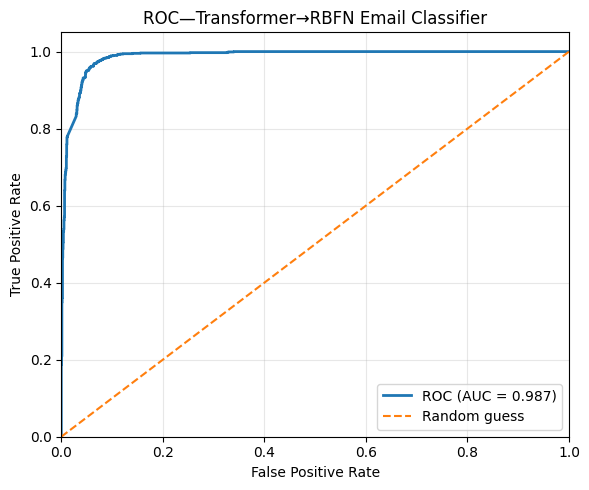

In [6]:
# Install necessary packages
!pip install -q transformers accelerate datasets evaluate scikit-learn torch torchvision torchaudio

import pandas as pd
import numpy as np
import time
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from collections import Counter
from sklearn.cluster import KMeans
from numpy.linalg import pinv
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve, auc

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ================================
# 1. Load and process URL data
# ================================
print("Loading URL data...")
url_df = pd.read_csv('/content/drive/MyDrive/phishingemailurl/malicious_phish.csv')
print(f"URL Dataset shape: {url_df.shape}")

def simple_preprocess(url):
    if pd.isna(url):
        return ""
    url = str(url).replace('https://', '').replace('http://', '').replace('www.', '')
    return url.lower().strip()

url_df['clean_url'] = url_df['url'].apply(simple_preprocess)

def extract_simple_features(url):
    url = str(url)
    features = {}
    features['length'] = len(url)
    features['num_dots'] = url.count('.')
    features['num_slashes'] = url.count('/')
    features['num_digits'] = sum(c.isdigit() for c in url)
    features['has_https'] = 1 if 'https' in url else 0
    return features

# Extract features
features_list = []
for url in url_df['clean_url']:
    features_list.append(extract_simple_features(url))

features_df = pd.DataFrame(features_list)
url_df = pd.concat([url_df, features_df], axis=1)

# Prepare URL data
X_url_text = url_df['clean_url']
y_url = url_df['type']

# Convert labels to numerical values
le_url = LabelEncoder()
y_url_encoded = le_url.fit_transform(y_url)
url_labels = le_url.classes_

X_url_train_text, X_url_test_text, y_url_train, y_url_test = train_test_split(
    X_url_text, y_url_encoded, test_size=0.2, random_state=42, stratify=y_url_encoded
)

# Split features as well
feature_cols = ['length', 'num_dots', 'num_slashes', 'num_digits', 'has_https']
X_url_features = url_df[feature_cols].values
X_url_train_features, X_url_test_features, _, _ = train_test_split(
    X_url_features, y_url_encoded, test_size=0.2, random_state=42, stratify=y_url_encoded
)

# Vectorize URL text
print("Vectorizing URL text with TF-IDF...")
url_vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2)
)

X_url_train_vec = url_vectorizer.fit_transform(X_url_train_text)
X_url_test_vec = url_vectorizer.transform(X_url_test_text)

X_url_train_vec_dense = X_url_train_vec.toarray()
X_url_test_vec_dense = X_url_test_vec.toarray()

# Combine URL text features with handcrafted features
X_url_train_combined = np.hstack([X_url_train_vec_dense, X_url_train_features])
X_url_test_combined = np.hstack([X_url_test_vec_dense, X_url_test_features])

print(f"URL Training data shape: {X_url_train_combined.shape}")
print(f"URL Test data shape: {X_url_test_combined.shape}")

# Train URL Random Forest classifier
print("Training URL Random Forest...")
url_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

url_clf.fit(X_url_train_combined, y_url_train)

# Make URL predictions
y_url_pred = url_clf.predict(X_url_test_combined)

print("URL Accuracy:", (y_url_pred == y_url_test).mean())
print("\nURL Classification Report:")
print(classification_report(y_url_test, y_url_pred, target_names=url_labels))

# ================================
# 2. Load and process Email data
# ================================
print("\nLoading Email data...")
email_df = pd.read_csv("/content/drive/MyDrive/phishingemailurl/Phishing_Email.csv")

print("Email Columns:", list(email_df.columns))
print(email_df.head())

TEXT_COL = "Email Text"
LABEL_COL = "Email Type"

# Map labels: "Safe Email" -> 0, "Phishing Email" -> 1
label_map_exact = {"Safe Email": 0, "Phishing Email": 1}
assert {TEXT_COL, LABEL_COL}.issubset(email_df.columns), f"Missing columns. Found: {email_df.columns}"

email_df = email_df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)
email_df[TEXT_COL] = email_df[TEXT_COL].astype(str)

y_email = email_df[LABEL_COL].map(label_map_exact)
# Safety fallback if formatting differs slightly
if y_email.isna().any():
    y_email = email_df[LABEL_COL].astype(str).str.strip().str.lower().map({"safe email":0, "phishing email":1})

# Final sanity check: ONLY these two labels allowed
assert y_email.isin([0,1]).all(), f"Labels must be only 'Safe Email'/'Phishing Email'. Got: {email_df[LABEL_COL].unique()}"

X_email_all = email_df[TEXT_COL].tolist()
y_email = y_email.to_numpy()

# Stratified 70/15/15 split
train_idx, temp_idx, _, y_temp = train_test_split(
    np.arange(len(X_email_all)), y_email, test_size=0.30, stratify=y_email, random_state=42
)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

X_email_train = [X_email_all[i] for i in train_idx]
X_email_val   = [X_email_all[i] for i in val_idx]
X_email_test  = [X_email_all[i] for i in test_idx]

y_email_train, y_email_val, y_email_test = y_email[train_idx], y_email[val_idx], y_email[test_idx]
print("Email Splits:", len(X_email_train), len(X_email_val), len(X_email_test))

# Email embedding with transformer
MODEL = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(MODEL)
enc = AutoModel.from_pretrained(MODEL).to(device).eval()

@torch.inference_mode()
def embed_texts(texts, batch_size=32, max_len=256):
    out = []
    for i in tqdm(range(0, len(texts), batch_size)):
        t = tok(texts[i:i+batch_size], padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)
        h = enc(**t).last_hidden_state                  # [B, L, H]
        mask = t.attention_mask.unsqueeze(-1)           # [B, L, 1]
        pooled = (h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        out.append(pooled.cpu())
    return torch.vstack(out).numpy()

t0 = time.time()
X_email_train_emb = embed_texts(X_email_train)
X_email_val_emb   = embed_texts(X_email_val)
X_email_test_emb  = embed_texts(X_email_test)
print(f"Email Embedding time (min): {(time.time()-t0)/60:.2f}")

# RBF functions
def pairwise_sq_dists(A, B):
    A2 = np.sum(A*A, axis=1, keepdims=True)
    B2 = np.sum(B*B, axis=1, keepdims=True).T
    return A2 + B2 - 2 * A @ B.T

def make_rb_features(X, centers, sigma=None):
    d2 = pairwise_sq_dists(X, centers)
    if sigma is None:
        c_d2 = pairwise_sq_dists(centers, centers)
        mask = c_d2 > 0
        sigma = np.sqrt(np.mean(c_d2[mask])) if np.any(mask) else 1.0
        if not np.isfinite(sigma) or sigma == 0: sigma = 1.0
    Phi = np.exp(-d2 / (2 * sigma**2 + 1e-12))
    Phi = np.hstack([Phi, np.ones((X.shape[0], 1))])  # bias
    return Phi, sigma

def one_hot(y, num_classes=2):
    Y = np.zeros((y.shape[0], num_classes))
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

def fit_rbf_ridge_weighted(X, y, centers, class_weights, l2=1e-2, sigma=None, num_classes=2):
    Phi, sigma = make_rb_features(X, centers, sigma)
    Y = one_hot(y, num_classes)
    # sample weights from class weights
    sw = np.array([class_weights[int(yi)] for yi in y], dtype=float)  # [N]
    WPhi = sw[:, None] * Phi
    A = Phi.T @ WPhi                        # Phi^T D Phi
    B = Phi.T @ (sw[:, None] * Y)           # Phi^T D Y
    I = np.eye(Phi.shape[1])
    W = pinv(A + l2 * I) @ B                # [M+1, C]
    return W, sigma

def predict_rbf(X, centers, W, sigma):
    Phi, _ = make_rb_features(X, centers, sigma)
    Z = Phi @ W
    Zexp = np.exp(Z - Z.max(axis=1, keepdims=True))
    P = Zexp / Zexp.sum(axis=1, keepdims=True)      # [N, 2]
    yhat = np.argmax(P, axis=1)
    return yhat, P

# Train RBF model for emails
counts = Counter(y_email_train)        # {0: safe_count, 1: phish_count}
total = sum(counts.values())
class_weights = {c: total/(2*counts[c]) for c in counts}  # inverse frequency
print("Email Class weights:", class_weights)

best = {"f1": -1, "K": None, "l2": None, "centers": None, "W": None, "sigma": None}
K_grid  = [32, 64, 96, 128]           # tweak as you like
l2_grid = [1e-3, 3e-3, 1e-2, 3e-2]

t_grid = time.time()
for K in K_grid:
    t_km = time.time()
    km = KMeans(n_clusters=K, random_state=42, n_init='auto').fit(X_email_train_emb)
    centers = km.cluster_centers_
    print(f"KMeans K={K} time (min): {(time.time()-t_km)/60:.2f}")
    for l2 in l2_grid:
        t1 = time.time()
        W, sigma = fit_rbf_ridge_weighted(X_email_train_emb, y_email_train, centers, class_weights, l2=l2, num_classes=2)
        yv_hat, _ = predict_rbf(X_email_val_emb, centers, W, sigma)
        f1m = f1_score(y_email_val, yv_hat, average='weighted')
        print(f"  K={K:3d}  l2={l2:.4g}  VAL weighted F1={f1m:.4f}  (min: {(time.time()-t1)/60:.2f})")
        if f1m > best["f1"]:
            best.update({"f1": f1m, "K": K, "l2": l2, "centers": centers, "W": W, "sigma": sigma})

print(f"\nBest VAL F1={best['f1']:.4f} with K={best['K']}  l2={best['l2']}")
print(f"Grid search time (min): {(time.time()-t_grid)/60:.2f}")

# Test email model
y_email_test_hat, Ptest = predict_rbf(X_email_test_emb, best["centers"], best["W"], best["sigma"])
print("Transformer → RBFN (Email TEST)")
print(classification_report(y_email_test, y_email_test_hat, digits=4, target_names=["Safe Email", "Phishing Email"]))

# ================================
# 3. Combined prediction function
# ================================
def predict_phishing(content, content_type="url"):
    """
    Predict if content is phishing or not

    Parameters:
    content (str): The URL or email text to analyze
    content_type (str): "url" or "email"

    Returns:
    dict: Prediction results
    """

    if content_type == "url":
        # URL prediction
        clean_url = simple_preprocess(content)

        # Vectorize the URL
        url_vec = url_vectorizer.transform([clean_url])

        # Extract features
        url_features = np.array([[
            len(clean_url),
            clean_url.count('.'),
            clean_url.count('/'),
            sum(c.isdigit() for c in clean_url),
            1 if 'https' in content else 0
        ]])

        # Convert to appropriate format
        url_vec_dense = url_vec.toarray()

        # Combine features
        url_combined = np.hstack([url_vec_dense, url_features])

        # Make prediction
        prediction = url_clf.predict(url_combined)
        probability = url_clf.predict_proba(url_combined)
        confidence = np.max(probability)

        return {
            'content': content,
            'type': 'url',
            'prediction': url_labels[prediction[0]],
            'confidence': confidence,
            'is_phishing': 'phish' in url_labels[prediction[0]].lower() or 'malicious' in url_labels[prediction[0]].lower()
        }

    else:  # email
        # Email prediction
        enc.eval()
        with torch.inference_mode():
            t = tok([content], padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
            h = enc(**t).last_hidden_state
            mask = t.attention_mask.unsqueeze(-1)
            emb = ((h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)).cpu().numpy()
        yhat, P = predict_rbf(emb, best["centers"], best["W"], best["sigma"])
        label = "Phishing Email" if yhat[0] == 1 else "Safe Email"

        return {
            'content': content,
            'type': 'email',
            'prediction': label,
            'confidence': P[0][yhat[0]],
            'is_phishing': yhat[0] == 1
        }

os.makedirs("figures", exist_ok=True)

# True labels and phishing probability (class 1)
y_true  = y_email_test
y_score = Ptest[:, 1]           # probability of "Phishing Email"

# Compute ROC and AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
print(f"Email ROC AUC: {roc_auc:.4f}")

# Plot + save for the paper
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], lw=1.5, linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC—Transformer→RBFN Email Classifier")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/email_roc.png", dpi=300)
plt.show()

In [7]:
import pandas as pd
import torch

# 1) Load
test_df = pd.read_csv("/content/drive/MyDrive/phishingemailurl/CEAS_08.csv")
assert "body" in test_df.columns and "label" in test_df.columns, \
    f"Expected 'body' and 'label', found: {test_df.columns.tolist()}"

# 2) Normalize labels to 0/1 (0=Safe, 1=Phishing)
def normalize_label(x: str):
    s = str(x).strip().lower()
    if s in ("true","1","phishing","phish","spam"):
        return 1
    if s in ("false","0","safe","ham","legit","legitimate"):
        return 0
    return None  # unknown / bad label

test_df["label_norm"] = test_df["label"].apply(normalize_label)
test_df = test_df.dropna(subset=["label_norm"]).reset_index(drop=True)
test_df["label_norm"] = test_df["label_norm"].astype(int)
test_df["body"] = test_df["body"].astype(str).fillna("")

# 3) Sample N rows
n_samples = 1000  # change to 10 if you want only 10
n_samples = min(n_samples, len(test_df))
sample_df = test_df.sample(n_samples, random_state=42).reset_index(drop=True)

# 4) Your trained model predictor (no printing inside)
#    Assumes: enc, tok, device, predict_rbf, best, and INV_LABEL exist from training.
#    If INV_LABEL isn't defined, define it:
try:
    INV_LABEL
except NameError:
    INV_LABEL = {0: "Safe Email", 1: "Phishing Email"}

def predict_email_type(email_text: str):
    enc.eval()
    with torch.inference_mode():
        t = tok([email_text], padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
        h = enc(**t).last_hidden_state
        mask = t.attention_mask.unsqueeze(-1)
        emb = ((h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)).cpu().numpy()
    yhat, P = predict_rbf(emb, best["centers"], best["W"], best["sigma"])
    label = INV_LABEL[int(yhat[0])]  # "Safe Email" or "Phishing Email"
    return label

# 5) Wrap to return 0/1
def safe_predict_to01(text: str) -> int:
    try:
        lab = str(predict_email_type(text)).strip().lower()
        return 1 if lab.startswith("phish") else 0
    except Exception:
        return 0  # fallback to Safe

sample_df["pred_email"] = sample_df["body"].apply(safe_predict_to01)

# 6) Nicely formatted side-by-side view (truncate body for readability)
def truncate(s, n=120):
    s = str(s)
    return s if len(s) <= n else s[:n] + "…"

view = sample_df.copy()
view["body_preview"] = view["body"].apply(lambda s: truncate(s, 120))
print(view[["label_norm", "pred_email", "body_preview"]])

# 7) Accuracy on the sample
acc = (sample_df["pred_email"] == sample_df["label_norm"]).mean()
print(f"\nSample accuracy ({n_samples} rows): {acc:.2f}")

     label_norm  pred_email                                                                                         body_preview
0             0           0  Also, the sa-blacklist inclusion policy is at:\n\n   http://www.stearns.org/sa-blacklist/README....
1             1           1  \nSize DOES matter - change your life today!\n\nAmazing growth within just a few short weeks is ...
2             1           1  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= >THE DAILY TOP 10 >from CNN.com >T...
3             0           0  \nLet's say I wanted to return the actual dates of the postings I've\nmade in Pownce for metric ...
4             1           1  \nLove is the beginning of all the joy which nature has store for us. http://mu.eachunder.com\n\n\n
..          ...         ...                                                                                                  ...
995           0           0  Hi Lotfi,\n\nIt's certainly true that our definition of causality de


=== Meta-layer validation report (binary: 1=Phishing) ===
              precision    recall  f1-score   support

           0      0.948     0.965     0.957       114
           1      0.970     0.956     0.963       136

    accuracy                          0.960       250
   macro avg      0.959     0.960     0.960       250
weighted avg      0.960     0.960     0.960       250

Confusion matrix:
 [[110   4]
 [  6 130]]
AUC: 0.9629

Permutation importance (mean +/- std):
          email_pred01 +0.42640 ± +0.01708
     url_prob_phishing +0.05520 ± +0.00776
          url_top_conf +0.03360 ± +0.00784
   url_prob_defacement +0.00960 ± +0.00320
         url_high_risk +0.00640 ± +0.00543
               has_url +0.00000 ± +0.00000
       url_prob_benign +0.00000 ± +0.00000
      url_prob_malware +0.00000 ± +0.00000
     url_top_is_benign +0.00000 ± +0.00000
 url_top_is_defacement +0.00000 ± +0.00000
    url_top_is_malware +0.00000 ± +0.00000
   url_top_is_phishing +0.00000 ± +0.00000
    

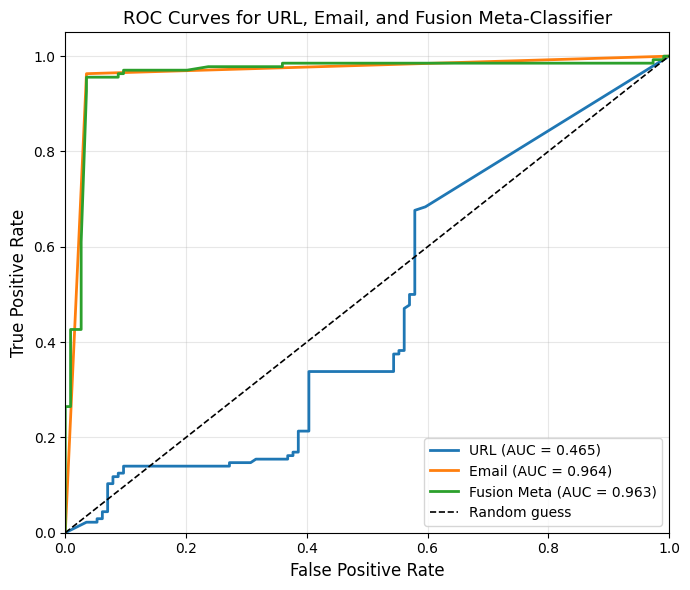

In [8]:
# meta_layer_training.py
import re
import numpy as np
import pandas as pd
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# =========================
# Prerequisites (must exist)
# =========================
_required = ["enc", "tok", "device", "predict_rbf", "best", "url_vectorizer", "url_clf", "url_labels"]
missing = [n for n in _required if n not in globals()]
if missing:
    raise RuntimeError(f"Missing required artifacts in globals: {missing}")

LABEL_MAP = {0: "benign", 1: "defacement", 2: "malware", 3: "phishing"}
BIN_LABELS = {"safe": 0, "phishing": 1}

# --------------------------
# Helpers: email model wrap
# --------------------------
def email_predict_to01(email_text: str) -> int:
    enc.eval()
    with torch.inference_mode():
        t = tok([email_text], padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
        h = enc(**t).last_hidden_state
        mask = t.attention_mask.unsqueeze(-1)
        emb = ((h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)).cpu().numpy()
        yhat, _ = predict_rbf(emb, best["centers"], best["W"], best["sigma"])
        return 1 if int(yhat[0]) == 1 else 0  # 1=Phishing Email, 0=Safe Email

# --------------------------
# Helpers: URL model wrap
# --------------------------
HTTP_ONLY_REGEX = re.compile(r'http://[^\s)<>\]"}]+', flags=re.IGNORECASE)

def extract_first_http_url(text: str):
    m = HTTP_ONLY_REGEX.search(text or "")
    if not m:
        return None
    return m.group(0).rstrip(').,;:!?"\'')

def url_preprocess(u: str):
    if u is None or (isinstance(u, float) and np.isnan(u)):
        return ""
    u = str(u).replace("https://", "").replace("http://", "").replace("www.", "")
    return u.lower().strip()

def url_predict_all(url_str: str):
    """Return (class_names, probs) where class_names are ['benign','defacement','malware','phishing'] if possible."""
    clean = url_preprocess(url_str)

    # Handcrafted feats
    feats = np.array([[len(clean), clean.count('.'), clean.count('/'), sum(c.isdigit() for c in clean), 1 if 'https' in clean else 0]], dtype=float)

    # Vectorize
    X_vec = url_vectorizer.transform([clean]).toarray()
    X = np.hstack([X_vec, feats])

    if not hasattr(url_clf, "predict_proba"):
        raise RuntimeError("url_clf must support predict_proba")

    proba = url_clf.predict_proba(X)[0]

    # Decide canonical class order
    if hasattr(url_clf, "classes_"):
        raw_classes = list(url_clf.classes_)
    else:
        raw_classes = list(url_labels)

    # Map raw to canonical names
    class_names = []
    for c in raw_classes:
        try:
            class_names.append(LABEL_MAP[int(c)])
        except Exception:
            class_names.append(str(c).lower())

    # Ensure we return probs in canonical order [benign, defacement, malware, phishing]
    # Build a mapping from returned class to index
    idx_map = {c: i for i, c in enumerate(class_names)}
    ordered = []
    for cname in ["benign", "defacement", "malware", "phishing"]:
        if cname in idx_map:
            ordered.append(proba[idx_map[cname]])
        else:
            ordered.append(0.0)

    return ["benign","defacement","malware","phishing"], np.array(ordered, dtype=float)

def url_top_type_and_conf(probs: np.ndarray, names=None):
    names = names or ["benign","defacement","malware","phishing"]
    i = int(np.argmax(probs))
    return names[i], float(probs[i])

def url_high_risk_rule(pred_type: str, conf: float) -> int:
    # include phishing too, with > 0.80
    return 1 if (pred_type in {"defacement","malware","phishing"} and conf > 0.80) else 0

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("/content/drive/MyDrive/phishingemailurl/CEAS_08.csv")
assert "body" in df.columns and "label" in df.columns, "CSV must have 'body' and 'label'"

# Normalize label to 0/1 for email-level ground truth (if your CSV has multi-class, adapt here)
def normalize_label_binary(x):
    s = str(x).strip().lower()
    if s in ("true","1","phishing","phish","spam"):
        return 1
    if s in ("false","0","safe","ham","legit","legitimate"):
        return 0
    return None

df["label_norm"] = df["label"].apply(normalize_label_binary)
df = df.dropna(subset=["label_norm"]).reset_index(drop=True)
df["label_norm"] = df["label_norm"].astype(int)
df["body"] = df["body"].astype(str).fillna("")

# Optional subsample to speed up dev
N = min(1000, len(df))
df = df.sample(N, random_state=42).reset_index(drop=True)

# --------------------------
# Feature construction
# --------------------------
records = []
for i, row in df.iterrows():
    body = row["body"]

    # Email model signal
    email_pred01 = email_predict_to01(body)  # 0/1

    # URL signals
    url = extract_first_http_url(body)
    has_url = 0 if (url is None or url == "") else 1

    if has_url:
        names, probs = url_predict_all(url)  # probs in [benign, defacement, malware, phishing]
        top_type, top_conf = url_top_type_and_conf(probs, names)
        high_risk = url_high_risk_rule(top_type, top_conf)
        # pack
        rec = {
            "label_norm": row["label_norm"],
            "email_pred01": email_pred01,
            "has_url": has_url,
            "url_prob_benign": probs[0],
            "url_prob_defacement": probs[1],
            "url_prob_malware": probs[2],
            "url_prob_phishing": probs[3],
            "url_top_type": top_type,
            "url_top_conf": top_conf,
            "url_high_risk": high_risk
        }
    else:
        rec = {
            "label_norm": row["label_norm"],
            "email_pred01": email_pred01,
            "has_url": has_url,
            "url_prob_benign": 0.0,
            "url_prob_defacement": 0.0,
            "url_prob_malware": 0.0,
            "url_prob_phishing": 0.0,
            "url_top_type": "none",
            "url_top_conf": 0.0,
            "url_high_risk": 0
        }

    records.append(rec)

feat_df = pd.DataFrame(records)

# Encode url_top_type as one-hot
for cname in ["benign","defacement","malware","phishing","none"]:
    feat_df[f"url_top_is_{cname}"] = (feat_df["url_top_type"] == cname).astype(int)

# Final feature set (you can tweak this list)
X_cols = [
    "email_pred01",
    "has_url",
    "url_prob_benign",
    "url_prob_defacement",
    "url_prob_malware",
    "url_prob_phishing",
    "url_top_conf",
    "url_high_risk",
    "url_top_is_benign",
    "url_top_is_defacement",
    "url_top_is_malware",
    "url_top_is_phishing",
    "url_top_is_none"
]
X = feat_df[X_cols].values
y = feat_df["label_norm"].values

# --------------------------
# Train/val split & training
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=123, stratify=y
)

# (for ROC sets) split indices identically to map back to per-modality signals
idx = np.arange(len(X))
idx_train, idx_val = train_test_split(
    idx, test_size=0.25, random_state=123, stratify=y
)

# Pipeline: scale then calibrated LR (Platt scaling via sigmoid)
base_lr = LogisticRegression(max_iter=200, class_weight="balanced", solver="lbfgs")
meta_clf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("cal", CalibratedClassifierCV(base_lr, method="sigmoid", cv=3))
])
meta_clf.fit(X_train, y_train)

# --------------------------
# Evaluation
# --------------------------
y_val_pred = meta_clf.predict(X_val)
y_val_proba = meta_clf.predict_proba(X_val)[:,1]

print("\n=== Meta-layer validation report (binary: 1=Phishing) ===")
print(classification_report(y_val, y_val_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))
try:
    auc_val = roc_auc_score(y_val, y_val_proba)
    print(f"AUC: {auc_val:.4f}")
except Exception:
    pass

# Permutation importance (rough sense of which stacked features help)
try:
    pi = permutation_importance(meta_clf, X_val, y_val, n_repeats=5, random_state=0)
    print("\nPermutation importance (mean +/- std):")
    for idx_pi in np.argsort(-pi.importances_mean):
        print(f"{X_cols[idx_pi]:>22s} {pi.importances_mean[idx_pi]:+.5f} ± {pi.importances_std[idx_pi]:+.5f}")
except Exception as e:
    print("\nPermutation importance not computed:", e)

# --------------------------
# Inference convenience
# --------------------------
def meta_build_features(email_text: str):
    ep = email_predict_to01(email_text)
    url = extract_first_http_url(email_text)
    if url:
        names, probs = url_predict_all(url)
        top_type, top_conf = url_top_type_and_conf(probs, names)
        hr = url_high_risk_rule(top_type, top_conf)
    else:
        probs = np.array([0.0,0.0,0.0,0.0], dtype=float)
        top_type, top_conf, hr = "none", 0.0, 0
    feats = {
        "email_pred01": ep,
        "has_url": 1 if url else 0,
        "url_prob_benign": probs[0],
        "url_prob_defacement": probs[1],
        "url_prob_malware": probs[2],
        "url_prob_phishing": probs[3],
        "url_top_conf": top_conf,
        "url_high_risk": hr,
        "url_top_is_benign": 1 if top_type=="benign" else 0,
        "url_top_is_defacement": 1 if top_type=="defacement" else 0,
        "url_top_is_malware": 1 if top_type=="malware" else 0,
        "url_top_is_phishing": 1 if top_type=="phishing" else 0,
        "url_top_is_none": 1 if top_type=="none" else 0
    }
    return np.array([feats[c] for c in X_cols], dtype=float)

def meta_predict(email_text: str):
    x = meta_build_features(email_text).reshape(1, -1)
    proba = meta_clf.predict_proba(x)[0,1]
    pred = int(proba >= 0.5)
    return {"pred_binary": pred, "pred_label": "Phishing" if pred==1 else "Safe", "prob_phishing": float(proba)}

# -------------
# Quick sanity
# -------------
ex = df.loc[0,"body"]
print("\nExample meta prediction:", meta_predict(ex))

# --- Prepare data for ROC curves (define the variables you plot) ---
# Treat URL model score as url_prob_phishing
url_prob_phishing = feat_df["url_prob_phishing"].values
# Treat the email model as a 0/1 score (will yield a valid ROC with two operating points)
email_pred01 = feat_df["email_pred01"].values.astype(float)

# Validation sets for each modality
y_url_test = y[idx_val]
P_url_test = np.column_stack([1.0 - url_prob_phishing[idx_val], url_prob_phishing[idx_val]])  # [:,1] is phishing prob

y_email_test = y[idx_val]
P_email_test = np.column_stack([1.0 - email_pred01[idx_val], email_pred01[idx_val]])  # [:,1] as "prob" proxy

y_meta_test = y_val
P_meta_test = np.column_stack([1.0 - y_val_proba, y_val_proba])

# --- Compute ROC curves ---
fpr_url, tpr_url, _ = roc_curve(y_url_test, P_url_test[:, 1])
roc_auc_url = auc(fpr_url, tpr_url)

fpr_email, tpr_email, _ = roc_curve(y_email_test, P_email_test[:, 1])
roc_auc_email = auc(fpr_email, tpr_email)

fpr_meta, tpr_meta, _ = roc_curve(y_meta_test, P_meta_test[:, 1])
roc_auc_meta = auc(fpr_meta, tpr_meta)

# --- Plot ---
os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(7,6))
plt.plot(fpr_url, tpr_url, lw=2, label=f"URL (AUC = {roc_auc_url:.3f})")
plt.plot(fpr_email, tpr_email, lw=2, label=f"Email (AUC = {roc_auc_email:.3f})")
plt.plot(fpr_meta, tpr_meta, lw=2, label=f"Fusion Meta (AUC = {roc_auc_meta:.3f})")
plt.plot([0,1], [0,1], 'k--', lw=1.2, label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves for URL, Email, and Fusion Meta-Classifier", fontsize=13)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/roc_meta.png", dpi=300)
plt.show()